# Spectral and temporal modifications Lab
### Jeanne MALÉCOT & Lou LE GALLO

*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [33]:
import os, sys, wave, struct

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from scipy import signal

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

## Functions

In [34]:
def load_sound(file):
    return wave.open(file, 'rb')
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = 2**int(np.ceil(np.log2(2*N-1)))
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [35]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [36]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [37]:
IPython.display.Audio('aeiou.wav')

In [38]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [39]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

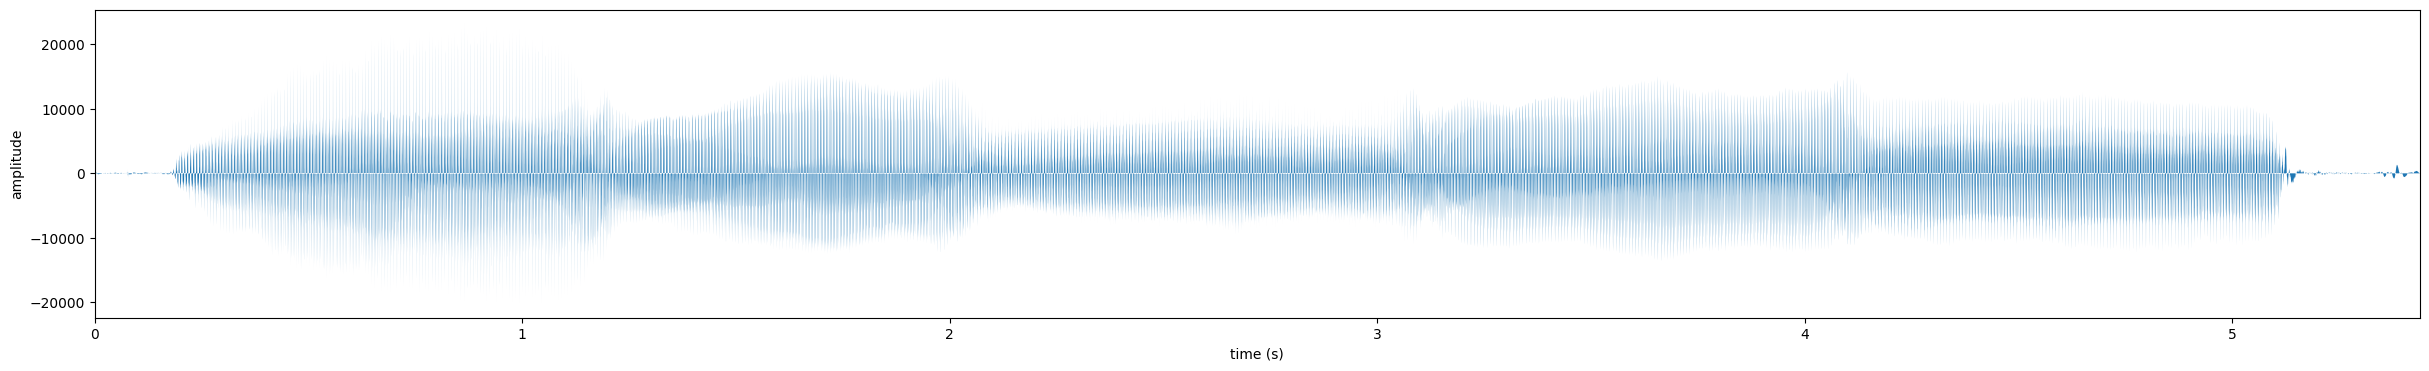

In [40]:
plot_sound(x, times)

In [41]:
write('new_aeiou.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

### 1. Extraction of the analysis marks

In [42]:
def AnalysisPitchMarks(s,Fs):
    """
    Extraction of the analysis marks
    Inputs :
        s : signal
        Fs : sampling frequency
    Output :
        A : matrix  of the times and pitches corresponding to each analysis mark 
    """
    n = len(s)

    ta = np.array([0])
    Pa = np.array([0.01*Fs])
    voiced = np.array([0])

    while (ta[-1] + 2.5*Pa[-1]) < n :

        x = s[int(ta[-1]):int(ta[-1]+2.5*Pa[-1])]
        P, v = period(x,Fs)

        Pa = np.append(Pa,P)
        voiced = np.append(voiced, v)
        ta = np.append(ta, ta[-1] + int(Pa[-1]))
 
    A = np.array([ta,voiced,Pa])
    return A

In [43]:
A = AnalysisPitchMarks(x, Fs)

In [44]:
A

array([[    0.  ,   110.  ,   220.  , ..., 59470.  , 59580.  , 59690.  ],
       [    0.  ,     0.  ,     0.  , ...,     0.  ,     0.  ,     0.  ],
       [  110.25,   110.  ,   110.  , ...,   110.  ,   110.  ,   110.  ]])

### 2. Synthesis and modification of the temporal and spectral scales

In [45]:
B = np.zeros((2, len(A[0])))
B[0,:] = A[0,:].astype(int)
B[1,:] = np.arange(len(A[0])).astype(int)

### 2.1. Signal synthesis

In [46]:
def Synthesis(s,Fs,A,B):
    """
    Synthesis of the signal s from the analysis marks
    Inputs :
        s : signal
        Fs : sampling frequency
        A : matrix  of the times and pitches corresponding to each analysis mark
        B : matrix of the times and indices corresponding to each synthesis mark
    Output :
        y : synthesized signal
    """
    ta = A[0]
    Pa = A[2]
    ts = B[0]
    N = B[1]

    y = np.zeros(int(ts[-1])+int(Pa[-1]))
    
    k = 0 

    while k < B.shape[1]:
        n_k = int(N[k])
        x = s[int(ta[n_k]-int(Pa[n_k])):int(ta[n_k]+int(Pa[n_k]))]
        ws = signal.windows.hann(len(x))
        y[int(ts[k]-int(Pa[n_k])):int(ts[k]+int(Pa[n_k]))] += x*ws

        k = k+1
        
    return y

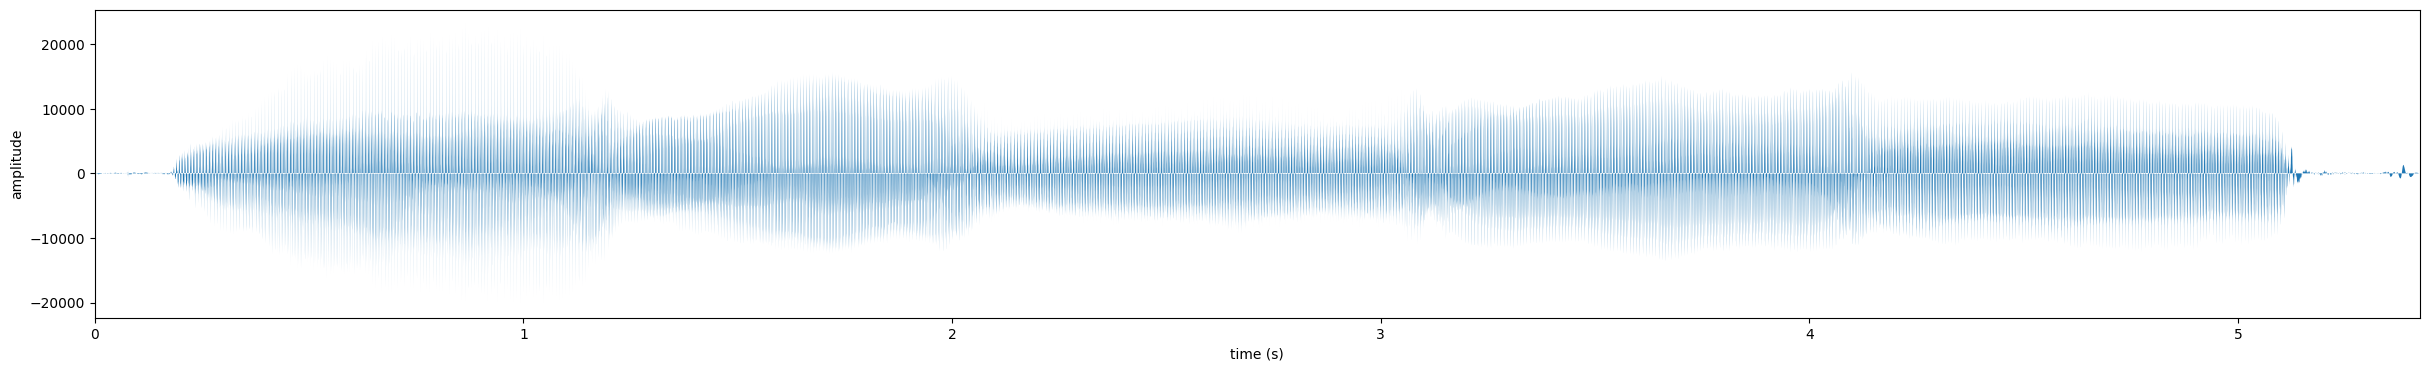

In [47]:
y = Synthesis(x, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

### 2.2. Modification of the temporal scale

In [48]:
def ChangeTimeScale(alpha, A, Fs):
    """
    Determine a matrix B such that the duration of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by alpha.
    Inputs :
        alpha : time scaling factor
        Fs : sampling frequency
        A : matrix  of the times and pitches corresponding to each analysis mark
    Output :
        B : matrix of the times and indices corresponding to each synthesis mark
    """     

    Pa = A[2,:]
    ts = [1]
    N = [0,1]
    length = int(N[-1])
    max_len = len(Pa)

    while(length < max_len):
        ts.append(ts[-1] + Pa[length])
        N.append(N[-1] + 1/alpha)
        length = int(N[-1])

    B = np.array([ts, N[:-1]]).astype(int)
    return B

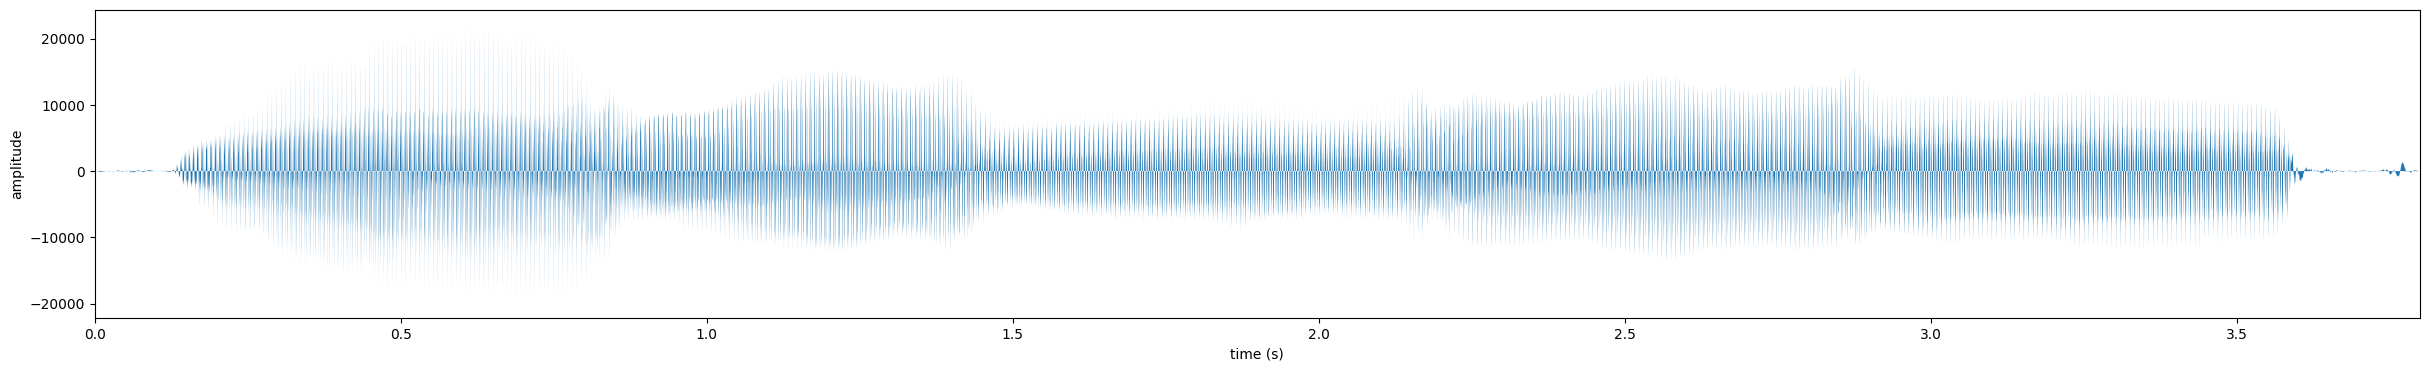

In [49]:
B = ChangeTimeScale(0.7, A, Fs)
y = Synthesis(x, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

write('y.wav', Fs, np.array(y, dtype=np.int16))
IPython.display.Audio('y.wav')

### 2.3. Modification of the spectral scale

In [50]:
def ChangePitchScale(beta, A, Fs):
    """
    Determine a matrix B such that the fundamental frequency of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by beta.

    Inputs :
        beta : pitch scaling factor
        Fs : sampling frequency
        A : matrix  of the times and pitches corresponding to each analysis mark
    Output :
        B : matrix of the times and indices corresponding to each synthesis mark
    """    
    ta = A[0,:]
    voiced = A[1,:]
    Pa = A[2,:]
    ts = [1]
    N = [0,1]
    
    scale = np.ones(len(A[1,:]))
    scale[voiced==1] = 1/beta

    length = int(N[-1])
    max_len = len(Pa)

    while(length < max_len):
        n_k = int(N[-1])
        ts.append(ts[-1] + scale[n_k]*Pa[n_k])
        N.append(N[-1] + scale[n_k])
        length = int(N[-1])
        
    B = np.array([ts, N[:-1]]).astype(int)
    return B

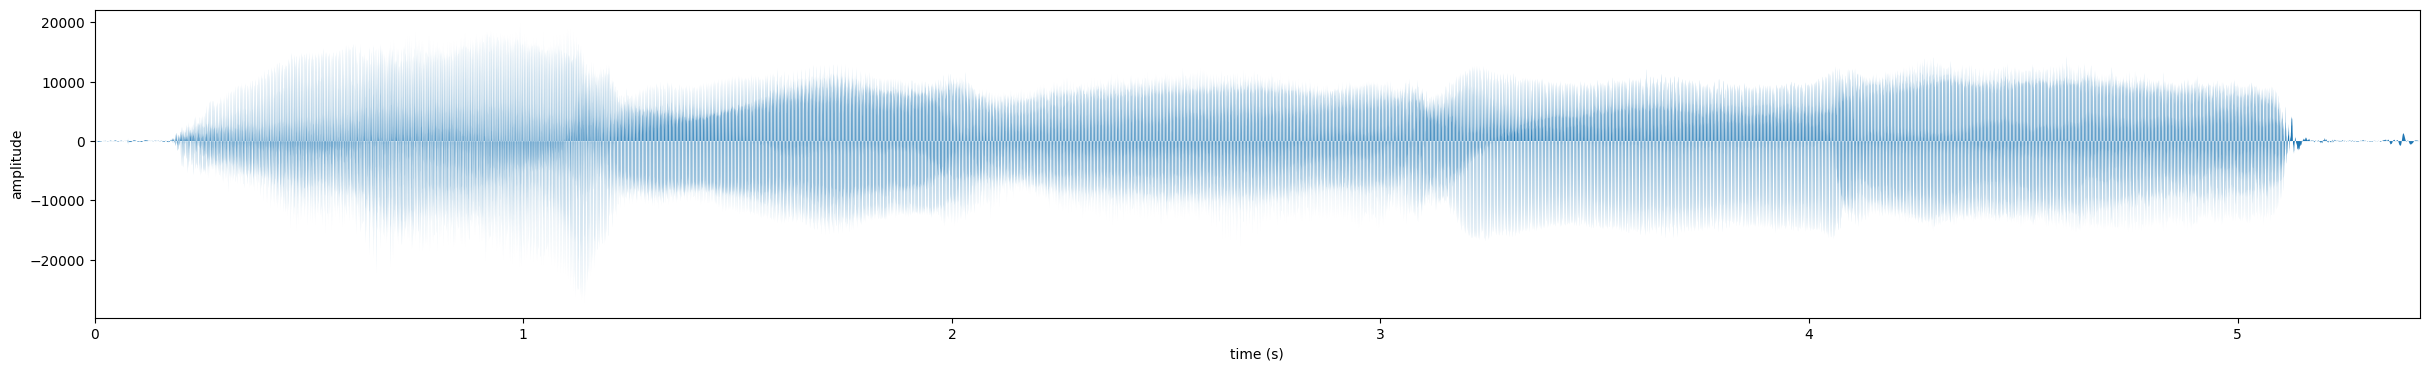

In [51]:
B = ChangePitchScale(2.3, A, Fs)
y = Synthesis(x, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

write('y.wav', Fs, np.array(y, dtype=np.int16))
IPython.display.Audio('y.wav')

### 2.4. Joint modification of the temporal and spectral scales

In [52]:
def ChangeBothScales(alpha, beta, A, Fs):
    """
    Determine a matrix B such that the fundamental frequency of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by beta and such that the duration of the signal synthesized by function Synthesis is equal to that of the original signal s multiplied by alpha.

    Inputs :
        alpha : time scaling factor
        beta : pitch scaling factor
        Fs : sampling frequency
        A : matrix  of the times and pitches corresponding to each analysis mark
    Output :
        B : matrix of the times and indices corresponding to each synthesis mark
    """    
    ta = A[0,:]
    voiced = A[1,:]
    Pa = A[2,:]
    ts = [1]
    N = [0,1]
    
    scale = np.ones(len(A[1,:]))
    scale[voiced==1] = 1/beta

    length = int(N[-1])
    max_len = len(Pa)

    while(length < max_len):
        n_k = int(N[-1])
        ts.append(ts[-1] + scale[n_k]*Pa[n_k])
        N.append(N[-1] + scale[n_k]/alpha)
        length = int(N[-1])
        
    B = np.array([ts, N[:-1]]).astype(int)
    return B

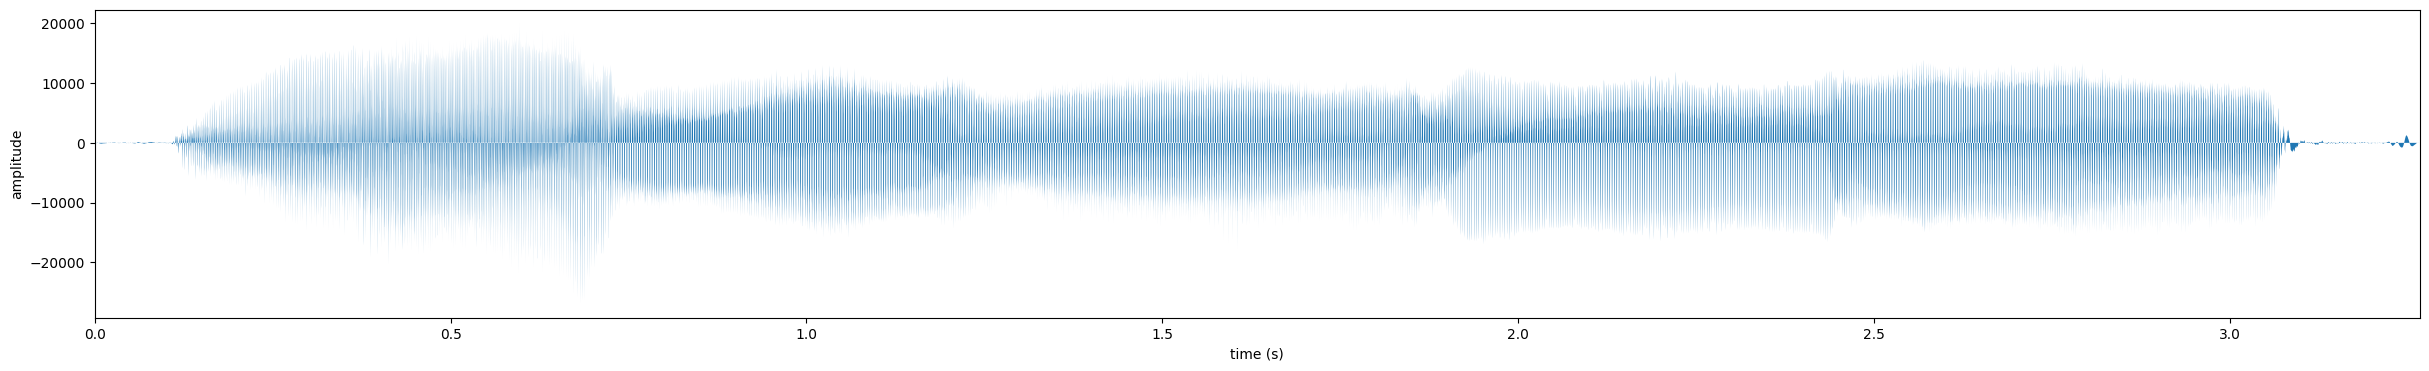

In [53]:
B = ChangeBothScales(0.6, 2.3, A, Fs)
y = Synthesis(x, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

write('y.wav', Fs, np.array(y, dtype=np.int16))
IPython.display.Audio('y.wav')